# Sample Preparation

## EDA

In [1]:
DATASET = 'FoCus'

LLM_LIST = [
    'Mistral-7B-Instruct', 'Llama3-1-8B-Instruct', 'Qwen2-7B-Instruct',
    'gpt-3.5-turbo', 'gpt-4-turbo', 'gpt-4o-mini'
            ]


In [2]:
import pandas as pd

all_dfs = []  # List to store all dataframes

for llm in LLM_LIST:
    # Read the Excel file for each LLM
    df = pd.read_excel(f"Metrics Results/{DATASET}/{llm}-detailed-results.xlsx")

    all_dfs.append(df)

# Combine all dataframes vertically
df = pd.concat(all_dfs, axis=0, ignore_index=True)

In [3]:
df.head(3)

,personas,context,act_response,gen_response,response_time,Coh-UniEval,C Score,UE Score,Persona Distance
0,I would like to visit the Nazareth House again...,User1: I think Ive been there before but I don...,The history of the house you are interested in...,NaN,4.346300,0.0,-1,0,0.0
1,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...",This house was use as a stop for slaves trying...,NaN,4.384920,0.0,-1,0,0.0
2,I am fascinated by the Spanish Colonial Reviva...,"User1: Wow, this is amazing! What is this?\nUs...","Sure, you will like to know that this place wa...",NaN,4.383095,0.0,-1,0,0.0


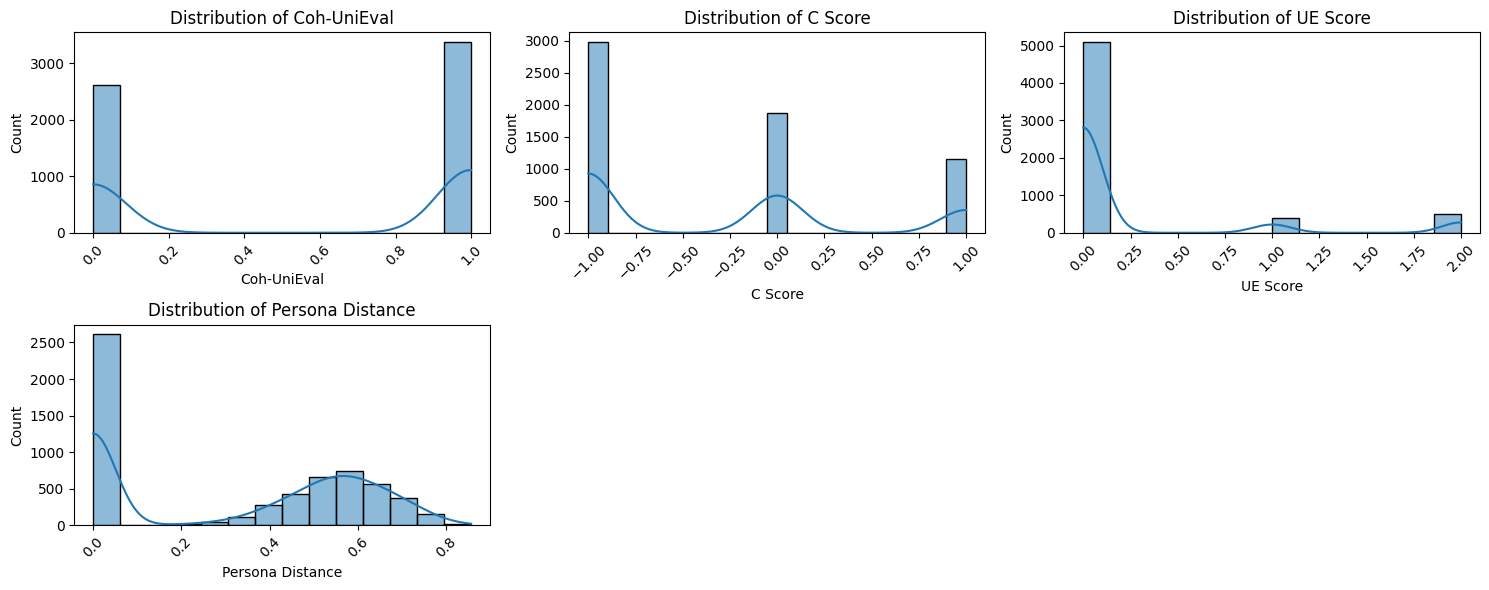

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a new column for NaN status

columns_to_analyze = ['Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance']

plt.figure(figsize=(15, 5*len(columns_to_analyze)//3))
for i, column in enumerate(columns_to_analyze, 1):
    plt.subplot(len(columns_to_analyze)//3 + 1, 3, i)
    sns.histplot(data=df, x=column, kde=True)  # kde=True adds a density curve
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
for col in  ['Coh-UniEval', 'C Score', 'UE Score', 'Persona Distance']:
    n_unique = df[col].value_counts()
    print(n_unique)

Coh-UniEval
0.000000    2611
0.998332       1
0.999686       1
0.998125       1
0.999801       1
            ... 
0.999155       1
0.998727       1
0.999494       1
0.999251       1
0.999385       1
Name: count, Length: 3390, dtype: int64
C Score
-1    2981
 0    1873
 1    1146
Name: count, dtype: int64
UE Score
0    5098
2     503
1     399
Name: count, dtype: int64
Persona Distance
0.000000    2611
0.148839       2
0.673752       2
0.551486       1
0.597194       1
            ... 
0.422656       1
0.567386       1
0.539090       1
0.496497       1
0.396748       1
Name: count, Length: 3388, dtype: int64


In [5]:
n_unique = df["C Score"].value_counts()
print(f"Number of unique C Score values: {n_unique}")

Number of unique C Score values: C Score
-1    2981
 0    1873
 1    1146
Name: count, dtype: int64


## Dataset Preparation

In [9]:
# First get unique context-persona pairs
unique_pairs = df[["personas", "context"]].drop_duplicates()
print(f"Total unique context-persona pairs: {len(unique_pairs)}")

unique_pairs

Total unique context-persona pairs: 1000


,personas,context
0,I would like to visit the Nazareth House again...,User1: I think Ive been there before but I don...
1,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs..."
2,I am fascinated by the Spanish Colonial Reviva...,"User1: Wow, this is amazing! What is this?\nUs..."
3,I want to become a college student. I want to ...,User1: Where is this place?\nUser2: Hello! Wel...
4,I like to visit england. I love church. I woul...,User1: Where is this place?\nUser2: This place...
...,...,...
995,I am working in a pharmacy. I would like to vi...,User1: I think Ive been there before but I don...
996,I have the fantasy about archaeological sites....,"User1: Wow, this is amazing! What is this?\nUs..."
997,I want to learn more about history. I love goi...,User1: Where is this place?\nUser2: Hello! Thi...
998,I love waterfalls. I like camping. I am fond o...,User1: Where is this place?\nUser2: This is th...


In [7]:
# Create a list to store valid pairs
valid_pairs = []

for _, pair in unique_pairs.iterrows():
    # Get all responses for this context-persona pair
    mask = (df["personas"] == pair["personas"]) & (df["context"] == pair["context"])
    responses = df[mask]
    
    # Check if we have valid responses for both categories
    pos_responses = responses[
        (responses["C Score"] == 1) & 
        (responses["gen_response"].notna())
    ]["gen_response"]
    
    neg_responses = responses[
        (responses["C Score"].isin([0, -1])) &  # Combined negative scores
        (responses["gen_response"].notna())
    ]["gen_response"]
    
    # Only proceed if we have both positive and negative responses
    if len(pos_responses) > 0 and len(neg_responses) > 0:
        # Add positive responses
        for response in pos_responses:
            valid_pairs.append({
                'personas': pair["personas"],
                'context': pair["context"],
                'response': response,
                'score_type': 'positive'  # Add a label to distinguish positive/negative
            })
            
        # Add negative responses
        for response in neg_responses:
            valid_pairs.append({
                'personas': pair["personas"],
                'context': pair["context"],
                'response': response,
                'score_type': 'negative'  # Add a label to distinguish positive/negative
            })

valid_pairs_df = pd.DataFrame(valid_pairs)
print(f"\nTotal rows in final DataFrame: {len(valid_pairs_df)}")

valid_pairs_df



Total rows in final DataFrame: 1835


,personas,context,response,score_type
0,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...",The Truman Galusha House has been used as a sc...,positive
1,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...","This historic home in Jericho, Vermont, was na...",positive
2,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...","The Truman Galusha House has a rich history, i...",positive
3,I have been to Vermont a few times to go skiin...,"User1: Wow, this is amazing! What is this?\nUs...",The Truman Galusha House served as a meeting p...,negative
4,I would like to go to University. I live in Mi...,User1: I think Ive been there before but I don...,Oakland University offers a wide range of unde...,positive
...,...,...,...,...
1830,I want to learn more about history. I love goi...,User1: Where is this place?\nUser2: Hello! Thi...,"Armagh County Museum was established in 1937, ...",positive
1831,I want to learn more about history. I love goi...,User1: Where is this place?\nUser2: Hello! Thi...,Armagh County Museum is owned by the Armagh Ci...,positive
1832,I want to learn more about history. I love goi...,User1: Where is this place?\nUser2: Hello! Thi...,The Armagh County Museum is owned by the Armag...,negative
1833,I love waterfalls. I like camping. I am fond o...,User1: Where is this place?\nUser2: This is th...,"I'm glad you mentioned the rainforest, I've al...",positive


In [8]:
# Method 1: Get count of unique personas
print("Number of unique personas:", valid_pairs_df['personas'].nunique())

# Method 2: Get count of unique contexts
print("Number of unique contexts:", valid_pairs_df['context'].nunique())

# Method 3: Get count of unique persona-context pairs
unique_pairs_count = valid_pairs_df.groupby(['personas', 'context']).size().reset_index(name='count')
print("\nNumber of unique persona-context pairs:", len(unique_pairs_count))


Number of unique personas: 443
Number of unique contexts: 445

Number of unique persona-context pairs: 445


In [16]:
import pandas as pd

def prepare_dpo_dataset(df):
    """
    Filters and reformats the dataset to keep only those prompt groups that have both
    positive and negative responses. Returns a DataFrame with one (chosen, rejected) pair per prompt.
    """
    df["prompt"] = df.apply(lambda row: f"Persona: {row['personas']}\nContext: {row['context']}", axis=1)
    
    grouped = df.groupby("prompt")
    dpo_records = []

    for prompt, group in grouped:
        pos = group[group['score_type'] == 'positive']['response']
        neg = group[group['score_type'] == 'negative']['response']
        
        if not pos.empty and not neg.empty:
            print(f"Prompt group:\n{prompt[:50]}...\n  → Positives: {len(pos)}, Negatives: {len(neg)}")
            dpo_records.append({
                "prompt": prompt,
                "chosen": pos.iloc[0],
                "rejected": neg.iloc[0]
            })

    return pd.DataFrame(dpo_records)


dpo_df = prepare_dpo_dataset(valid_pairs_df)


Prompt group:
Persona: I am American. Ive never been to Illinois...
  → Positives: 3, Negatives: 3
Prompt group:
Persona: I am Australian. I love water slides. I w...
  → Positives: 1, Negatives: 3
Prompt group:
Persona: I am Korean. I love art. I like gardens. ...
  → Positives: 4, Negatives: 1
Prompt group:
Persona: I am Roman Catholic. I am living in India...
  → Positives: 3, Negatives: 2
Prompt group:
Persona: I am a Scout. I have a Ranch. I would lik...
  → Positives: 2, Negatives: 4
Prompt group:
Persona: I am a big fan of New York City. I love t...
  → Positives: 1, Negatives: 2
Prompt group:
Persona: I am a citizen of the United States. I lo...
  → Positives: 3, Negatives: 2
Prompt group:
Persona: I am a citizen of the United States. I wo...
  → Positives: 2, Negatives: 3
Prompt group:
Persona: I am a huge fan of The Rolling Stones. I ...
  → Positives: 2, Negatives: 2
Prompt group:
Persona: I am a huge fan of learning about the his...
  → Positives: 2, Negatives: 3
Prompt gro

In [18]:
print(f"\nTotal rows in DPO DataFrame: {len(dpo_df)}")
dpo_df.head(10)


Total rows in DPO DataFrame: 445


,prompt,chosen,rejected
0,Persona: I am American. Ive never been to Illi...,"As an American history enthusiast, I'm thrille...","Yes, the Cahokia Mounds State Historic Site is..."
1,Persona: I am Australian. I love water slides....,I'm glad you asked about dining options. White...,"At WhiteWater World, you can enjoy activities ..."
2,Persona: I am Korean. I love art. I like garde...,The museum has an impressive collection of scu...,You'll be pleased to know that the museum has ...
3,Persona: I am Roman Catholic. I am living in I...,Saint Mary-of-the-Woods College is a great opt...,"Yes, Saint Mary-of-the-Woods College is open t..."
4,Persona: I am a Scout. I have a Ranch. I would...,"As a Scout, I'm thrilled to share that Philmon...",The Philmont Scout Ranch was donated by Waite ...
5,Persona: I am a big fan of New York City. I lo...,Some of the most famous buildings within Rocke...,Rockefeller Center is a vast complex in Manhat...
6,Persona: I am a citizen of the United States. ...,"As an INFP, I appreciate the natural beauty an...",Everglades National Park is located in the sou...
7,Persona: I am a citizen of the United States. ...,"The Jarvis Island is a small coral island, and...","Jarvis Island, a small coral gem in the South ..."
8,Persona: I am a huge fan of The Rolling Stones...,You'll be thrilled to know that The Rolling St...,The Rolling Stones first performed at the Marq...
9,Persona: I am a huge fan of learning about the...,"The fort is now a popular tourist attraction, ...","Today, you can find remnants of the fort's ori..."


In [19]:
import json

with open("dpo_dataset.jsonl", "w", encoding="utf-8") as f:
    for _, row in dpo_df.iterrows():
        json.dump(row.to_dict(), f)
        f.write("\n")

# LLM Loading

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

hf_token = os.getenv("HF_TOKEN")

In [2]:
llms_info = {
    "Mistral-7B-Instruct": {
        "remote_model_name": "mistralai/Mistral-7B-Instruct-v0.2",
        "model_path": "./LLMs/Mistral-7B-Instruct",
        "tokenizer_path": "./Tokenizers/Mistral-7B-Instruct",
        "hf_token": hf_token,
        "additional_config": {
            "torch_dtype": "auto",
            "device": "auto"
        }
    },
    "Qwen2-7B-Instruct": {
        "remote_model_name": "Qwen/Qwen2-7B-Instruct",
        "model_path": "./LLMs/Qwen2-7B-Instruct",
        "tokenizer_path": "./Tokenizers/Qwen2-7B-Instruct",
        "additional_config": {
            "torch_dtype": "auto",
            "trust_remote_code": True,
            "device": "auto"
        }
    }, 
    "Llama3-1-8B-Instruct": {# Size: - , system RAM: 20 GB (Windows)
        "remote_model_name": "meta-llama/Meta-Llama-3.1-8B-Instruct",
        "model_path": "./LLMs/Llama3-1-8B-Instruct",
        "tokenizer_path": "./Tokenizers/Llama3-1-8B-Instruct",
        "additional_config": {
            
           "rope_scaling": {
            "type": "linear",
            "factor": 8.0
            }
        }
    },
    "Phi-2": {
    "remote_model_name": "microsoft/phi-2",
    "model_path": "./LLMs/Phi-2",
    "tokenizer_path": "./Tokenizers/Phi-2",
    "additional_config": {
        "torch_dtype": "auto",
        "device": "auto"
    }
}

}

In [3]:
import os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

def load_model(model_key):
    model_info = llms_info[model_key]
    config = model_info["additional_config"]

    # Check if the directories for the model and tokenizer exist
    model_dir_exists = os.path.isdir(model_info["model_path"])
    tokenizer_dir_exists = os.path.isdir(model_info["tokenizer_path"])

    if model_dir_exists and tokenizer_dir_exists:
        print(f"{model_key} model and tokenizer are already present.")
    else:
        print(f"Downloading and saving model and tokenizer for {model_key}.")
        # Include the token in the download process if applicable
        hf_token = model_info.get("hf_token", None)
        model = AutoModelForCausalLM.from_pretrained(
            model_info["remote_model_name"],
            cache_dir=model_info["model_path"],
            torch_dtype=getattr(torch, config.get("torch_dtype", "auto")) if config.get("torch_dtype", "auto") != "auto" else None,
            use_auth_token=hf_token
        )
        tokenizer = AutoTokenizer.from_pretrained(
            model_info["remote_model_name"],
            cache_dir=model_info["tokenizer_path"],
            use_auth_token=hf_token
        )
        # Ensure directories are created during download
        if not model_dir_exists:
            os.makedirs(model_info["model_path"], exist_ok=True)
        if not tokenizer_dir_exists:
            os.makedirs(model_info["tokenizer_path"], exist_ok=True)
        # Save them locally
        model.save_pretrained(model_info["model_path"])
        tokenizer.save_pretrained(model_info["tokenizer_path"])

    # Load model and tokenizer from local storage
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    model = AutoModelForCausalLM.from_pretrained(model_info["model_path"], device_map="auto")
    model.config.use_cache = False
    tokenizer = AutoTokenizer.from_pretrained(model_info["tokenizer_path"])
    return model, tokenizer


/mnt/shared/Saleh/contextual_personalization/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import warnings
import logging
import torch

warnings.filterwarnings("ignore")
logging.getLogger('transformers').setLevel(logging.ERROR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# DPO

In [ ]:
# pip show trl transformers 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Name: trl
Version: 0.16.1
Summary: Train transformer language models with reinforcement learning.
Home-page: https://github.com/huggingface/trl
Author: Leandro von Werra
Author-email: leandro.vonwerra@gmail.com
License: Apache 2.0
Location: /mnt/shared/Saleh/contextual_personalization/.venv/lib/python3.10/site-packages
Requires: accelerate, datasets, rich, transformers
Required-by: 
---
Name: transformers
Version: 4.51.3
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /mnt/shared/Saleh/contextual_personalization/.venv/lib/python3.10/site-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: trl
Note: 

In [ ]:
# pip install --upgrade transformers accelerate dotenv

In [ ]:
# pip install --upgrade trl

In [5]:
from datasets import load_dataset

# Load the JSONL file as a HuggingFace dataset
dataset = load_dataset("json", data_files="dpo_dataset.jsonl", split="train")

# Check a sample
dataset[0]


{'prompt': 'Persona: I am American. Ive never been to Illinois. I like learning about history. I enjoy being outside at the park. I care about the protection of historic sites.\nContext: User1: I know this place, but I dont remember the name of this place.\nUser2: This is Cahokia Mounds State Historic Site in Illinois. I know youve never been to there before.\nUser1: What used to be at this site?\nUser2: This site used to be a pre-Columbian Native American city from 1050–1350 CE. I got this information from my history books.\nUser1: Are the mounds currently being protected?\nUser2: Yes! Thank you for being concerned about the protection of these important sites. These mounds are one of the 24 UNESCO World Heritage Sites within the US.\nUser1: Is this site accessible to the public?',
 'chosen': "As an American history enthusiast, I'm thrilled to share that Cahokia Mounds State Historic Site in Illinois is a protected UNESCO World Heritage Site. It was once a pre-Columbian Native America

In [6]:
for i, sample in enumerate(dataset):
    if any(sample[k] is None or sample[k] == "" for k in ['prompt', 'chosen', 'rejected']):
        print(f"Issue at row {i}: {sample}")


In [7]:
# Load the model and tokenizer
model, tokenizer = load_model("Phi-2")

# Set tokenizer padding config
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left"

# Disable cache for gradient checkpointing
model.config.use_cache = False

# # Optional: move to half precision if not already handled in `load_model`
# model = model.to(dtype=torch.float16)

# (Optional) Log VRAM usage to make sure it's reasonable
print(f"Model loaded on: {next(model.parameters()).device}")
print(f"Tokenizer pad_token_id: {tokenizer.pad_token_id}")


Phi-2 model and tokenizer are already present.
Using device: cuda


Loading checkpoint shards: 100%|██████████| 3/3 [00:01<00:00,  1.63it/s]


Model loaded on: cuda:0
Tokenizer pad_token_id: 50256


In [8]:
class MyDPOProcessingClass:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
        self.pad_token_id = tokenizer.pad_token_id

    def __call__(self, example):
        return {
            "prompt_input_ids": self.tokenizer(
                example["prompt"], add_special_tokens=False, truncation=True, max_length=512
            )["input_ids"],
            "chosen_input_ids": self.tokenizer(
                example["chosen"], add_special_tokens=False, truncation=True, max_length=512
            )["input_ids"],
            "rejected_input_ids": self.tokenizer(
                example["rejected"], add_special_tokens=False, truncation=True, max_length=512
            )["input_ids"]
        }


In [9]:
from trl import DPOConfig, DPOTrainer

training_args = DPOConfig(
    output_dir="Phi2-DPO",
    logging_steps=10,
    padding_value=tokenizer.pad_token_id,
    
    # # Modify precision settings
    fp16=False,                   
    bf16=True,                    
    
    # Other optimization parameters
    gradient_accumulation_steps=4,
    per_device_train_batch_size=4,
    gradient_checkpointing=True,
    
    # Additional settings
    dataloader_num_workers=4,
    # disable_tqdm=False, 
)


trainer = DPOTrainer(
    model=model, 
    args=training_args, 
    train_dataset= dataset,
    processing_class= MyDPOProcessingClass
)


Tokenizing train dataset:   0%|          | 0/445 [00:00<?, ? examples/s]


TypeError: MyDPOProcessingClass.__init__() got an unexpected keyword argument 'add_special_tokens'

In [8]:
trainer.train()

{'loss': 63.4273, 'grad_norm': nan, 'learning_rate': 1e-06, 'rewards/chosen': nan, 'rewards/rejected': nan, 'rewards/accuracies': 0.0, 'rewards/margins': nan, 'logps/chosen': nan, 'logps/rejected': nan, 'logits/chosen': nan, 'logits/rejected': nan, 'epoch': 0.35714285714285715}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 8.666666666666667e-07, 'rewards/chosen': nan, 'rewards/rejected': nan, 'rewards/accuracies': 0.0, 'rewards/margins': nan, 'logps/chosen': nan, 'logps/rejected': nan, 'logits/chosen': nan, 'logits/rejected': nan, 'epoch': 0.7142857142857143}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 7.333333333333332e-07, 'rewards/chosen': nan, 'rewards/rejected': nan, 'rewards/accuracies': 0.0, 'rewards/margins': nan, 'logps/chosen': nan, 'logps/rejected': nan, 'logits/chosen': nan, 'logits/rejected': nan, 'epoch': 1.0714285714285714}
{'loss': 0.0, 'grad_norm': nan, 'learning_rate': 6e-07, 'rewards/chosen': nan, 'rewards/rejected': nan, 'rewards/accuracies': 0.0, 'rewards/m

KeyboardInterrupt: 